Ahora vamos a llevar a cabo una prueba práctica del algoritmo de teleportación. Para ello hemos llevado a cabo, a través de un cuaderno de jupyter, un experimento a través del cuál se demuestra como se realiza el paso de la información desde el qubit de Alice al de Bob, desde un punto de vista práctico.

Dicho código puede ejecutarse desde IBM QuantumLab.

In [ ]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector
from qiskit.ignis.verification import marginal_counts

Comenzamos almacenando en variables los diferentes métodos de ejecución del circuito para su posterior uso:

In [2]:
backend_unitary = Aer.get_backend('unitary_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')
backend_stvec = Aer.get_backend('statevector_simulator')
backend_sim = Aer.get_backend('aer_simulator')

Comenzamos construyendo el circuito donde los qbits $q_0$ y $q_1$ se corresponden con Alice, mientras que el qbit $q_2$ será para Bob.

In [3]:
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

A continuación, vamos a inicializar el qubit $q_0$. Para ello le asignaremos un valor aleatorio como vector de estados. Nuestro objetivo será ver que dicho valor se transporta correctamente al qubit $q_2$.

In [4]:
#Sacamos un vector aleatorio que inicialice el qbit q0
init_value = random_statevector(2)

#Creamos la puerta que inicializará el qbit
init_gate = Initialize(init_value)
init_gate.label = "init_value"

#Añadimos el la puerta que inicializa el qbit q0 a nuestro circuito
circuit.append(init_gate, [0])
circuit.barrier()

El valor con el cuál inicializamos $q_0$ será el siguiente

In [5]:
display(array_to_latex(init_value, prefix="|\\psi\\rangle ="))

<IPython.core.display.Latex object>

Para el segundo y tercer qbit será necesario aplicar en estado de Bell. Para ello introduciremos una puerta de Hadamard y otra CNOT en este orden.

In [6]:
circuit.h(qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])

circuit.draw()

┌─────────────────────────────────────────────────┐ ░           
q_0: ┤ init_value(0.41646+0.76195j,-0.021579-0.49551j) ├─░───────────
     └─────────────────────────────────────────────────┘ ░ ┌───┐     
q_1: ────────────────────────────────────────────────────░─┤ H ├──■──
                                                         ░ └───┘┌─┴─┐
q_2: ────────────────────────────────────────────────────░──────┤ X ├
                                                         ░      └───┘
c_0: ════════════════════════════════════════════════════════════════
                                                                     
c_1: ════════════════════════════════════════════════════════════════

A continuación, para poder llevar a cabo el algoritmo de teleportación, aplicamos en los qbits pertenecientes a Alice una transformación de la siguiente manera: una puerta CNOT para $q_0$ y $q_1$, y una de Hadamard para el qbit $q_0$.

In [7]:
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])

El circuito quedará de la siguiente forma:

In [8]:
circuit.draw()

┌─────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.41646+0.76195j,-0.021579-0.49551j) ├─░────────────░───■──»
     └─────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ────────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                         ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ────────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                         ░      └───┘ ░      »
c_0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
c_1: ════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌───┐
«q_0: ┤ H ├
«     └───┘
«q_1: ─────
«          
«q_2: ─────
«          
«c_0: ═════
«          
«c_1: ═════
«

Veamos la matriz que interviene en nuestro circuito.

In [9]:
unitary= execute(circuit,backend_unitary,shots=1024).result().get_unitary()
array_to_latex(unitary)


<IPython.core.display.Latex object>

Y este será el vector de estados final, tras aplicarse dicha parte del algoritmo:

In [10]:
final_state= execute(circuit,backend_stvec,shots=1024).result().get_statevector()
array_to_latex(final_state)

<IPython.core.display.Latex object>

Introducimos dos medidores para $q_0$ y $q_1$ y una barrera para separar el circuito de dichos medidores.

In [11]:
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])

circuit.draw()

┌─────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.41646+0.76195j,-0.021579-0.49551j) ├─░────────────░───■──»
     └─────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ────────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                         ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ────────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                         ░      └───┘ ░      »
c_0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
c_1: ════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌───┐ ░ ┌─┐   
«q_0: ┤ H ├─░─┤M├───
«     └───┘ ░ └╥┘┌─┐
«q_1: ──────░──╫─┤M├
«           ░  ║ └╥┘
«q_2: ──────░──╫──╫─
«           ░  ║  ║ 
«c_0: ═════════╩══╬═
«                 ║ 
«c_1: ════════════╩═
«

Por último, para descodificar la información transmitida al qbit $q_2$, aplicaremos dos condicionales a las puertas NOT y Z. De modo que si tienen valor 1 se aplicarán al estado. Así, se seguirá el esquema siguiente:

$$
00 \longrightarrow \text{no se aplica ninguna puerta cuántica}
$$
$$
01 \longrightarrow \text{se aplica la puerta cuántica  } X = \sigma_3
$$
$$
10 \longrightarrow \text{se aplica la puerta cuántica  } Z = \sigma_1
$$
$$
11 \longrightarrow \text{se aplican las puertas cuánticas  } XZ = \sigma_3 \sigma_1
$$

In [12]:
circuit.barrier(qreg_q[0], qreg_q[1],qreg_q[2])
circuit.x(2).c_if(creg_c[1], 1) 
circuit.z(2).c_if(creg_c[0], 1)

circuit.draw()

┌─────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.41646+0.76195j,-0.021579-0.49551j) ├─░────────────░───■──»
     └─────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ────────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                         ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ────────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                         ░      └───┘ ░      »
c_0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
c_1: ════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌───┐ ░ ┌─┐    ░           
«q_0: ┤ H ├─░─┤M├────░───────────
«     └───┘ ░ └╥┘┌─┐ ░           
«q_1: ──────░──╫─┤M├─░───────────
«           ░  ║ └╥┘ ░ ┌───┐┌───┐
«q_2: ──────░──╫──╫──░─┤ X ├┤ Z ├
«           ░  ║  ║  ░ └─╥─┘└─╥─┘
«c_0: ═════════╩══╬══════╬════■══
«                 ║      ║       
«c_1: ════════════╩══════■═══════
«

Vamos a comprobar si se ha llevado correctamente el experimento. En un ordenador cuántico no es posible mostrar el vector de estados, así que para comprobar si todo ha ido bien utilizaremos otra forma. La puerta *init* que hemos aplicado al qbit $q_0$ al principio del algoritmo, nos ha permitido pasar del estado inicial de nuestro circuito $|0\rangle$, a un estado aleatorio a partir del cual ibamos a inicializar el algoritmo. De este modo, aplicaremos la inversa de esta puerta *init* al qbit $q_2$. Si nos devuelve el estado $|0\rangle$ con un $100%$ de probabilidad, podremos asegurar que toda la información del qubit $q_0$ se ha transportado correctamente a $q_2$.

Procederemos del siguiente modo: tras meter una barrera para separar esta nueva parte, añadiremos la puerta inversa a $q_2$ y un medidor.

In [13]:
circuit.barrier(qreg_q[0], qreg_q[1],qreg_q[2]) #barrera de separación

#Añadimos la puerta inversa
inverse_init = init_gate.gates_to_uncompute()
circuit.append(inverse_init, [2])

#Creamos un nuevo registro clásico donde se apoyará el nuevo medidor
c_2 = ClassicalRegister(1)
circuit.add_register(c_2)

#Añadimos el medidor para el qubit q2
circuit.measure(2,2)

In [14]:
circuit.draw()

┌─────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.41646+0.76195j,-0.021579-0.49551j) ├─░────────────░───■──»
     └─────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ────────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                         ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ────────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                         ░      └───┘ ░      »
c_0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
c_1: ════════════════════════════════════════════════════════════════════════»
                                                                             »
 c0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌───┐ ░ ┌─┐    ░            ░                    
«q_0: ┤ H ├─░─┤M├────░────────────░────────────────────
«     └───┘ ░ └╥┘┌─┐ ░            ░                    
«q_1: ──────░──╫─┤M├─░────────────░────────────────────
«           ░  ║ └╥┘ ░ ┌───┐┌───┐ ░ ┌──────────────┐┌─┐
«q_2: ──────░──╫──╫──░─┤ X ├┤ Z ├─░─┤ disentangler ├┤M├
«           ░  ║  ║  ░ └─╥─┘└─╥─┘ ░ └──────────────┘└╥┘
«c_0: ═════════╩══╬══════╬════■══════════════════════╬═
«                 ║      ║                           ║ 
«c_1: ════════════╩══════■═══════════════════════════╬═
«                                                    ║ 
« c0: ═══════════════════════════════════════════════╩═
«

Llevamos a cabo la representación de nuestras mediciones a través de un histograma. 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_704504\2833224662.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import marginal_counts


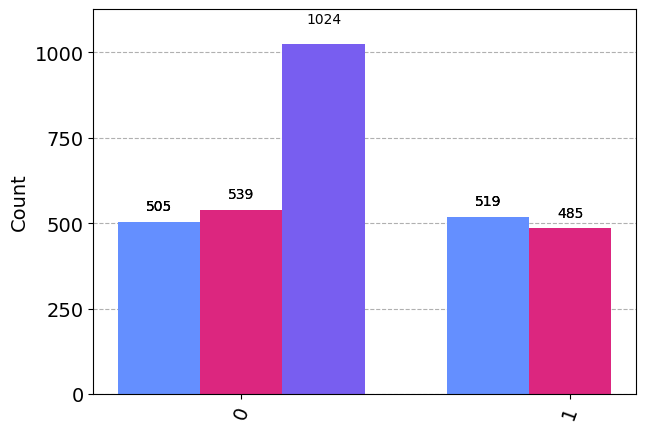

In [15]:
t_qc = transpile(circuit, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

Echando un ojo a nuestro histograma, vemos que todos los disparos se miden finalmente con estado $|0\rangle$ para el caso del qubit $q_2$ representado con la barra morada. Con esto podemos concluir que con un $100\%$ de probabilidad nuestro experimento habrá transmitido toda la información de $q_0$ a $q_2$.

In [16]:
for i in range(3):
    circuit.data.pop(13) #borramos el vector de estados almacenado en nuestro circuito


In [17]:
circuit.draw()

┌─────────────────────────────────────────────────┐ ░            ░      »
q_0: ┤ init_value(0.41646+0.76195j,-0.021579-0.49551j) ├─░────────────░───■──»
     └─────────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
q_1: ────────────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                         ░ └───┘┌─┴─┐ ░ └───┘»
q_2: ────────────────────────────────────────────────────░──────┤ X ├─░──────»
                                                         ░      └───┘ ░      »
c_0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
c_1: ════════════════════════════════════════════════════════════════════════»
                                                                             »
 c0: ════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌───┐ ░ ┌─┐    ░           
«q_0: ┤ H ├─░─┤M├────░───────────
«     └───┘ ░ └╥┘┌─┐ ░           
«q_1: ──────░──╫─┤M├─░───────────
«           ░  ║ └╥┘ ░ ┌───┐┌───┐
«q_2: ──────░──╫──╫──░─┤ X ├┤ Z ├
«           ░  ║  ║  ░ └─╥─┘└─╥─┘
«c_0: ═════════╩══╬══════╬════■══
«                 ║      ║       
«c_1: ════════════╩══════■═══════
«                                
« c0: ═══════════════════════════
«

Ahora veamos graficamente si el vector de estados tras el algoritmo de $q_2$ correspondiente a la información que descodica Bob coincide con la inicialmente dispone Alice en $q_0$.

El vector inicial correspondiente a la información que quería transmitir Alice era el siguiente:

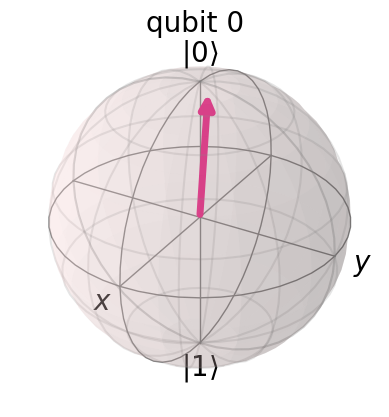

In [18]:
plot_bloch_multivector(init_value)

Comparándolo con los estados finales de los tres qbits, vemos que se ha transmitido correctamente al qbit $q_2$. Pues ambas representaciones coinciden.

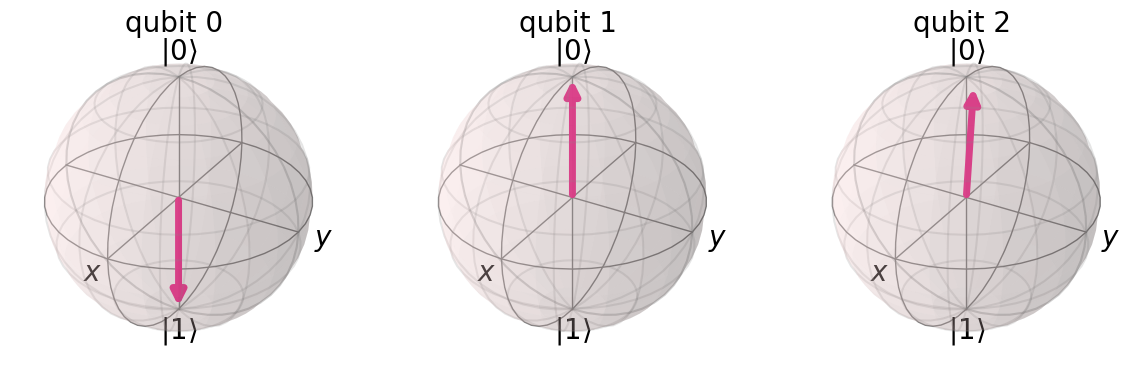

In [19]:

circuit.save_statevector()
out_vector = backend_sim.run(circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

Veamos ahora desde un punto de vista gráfico, el valor que adopta el vector de estados para los tres qbits:

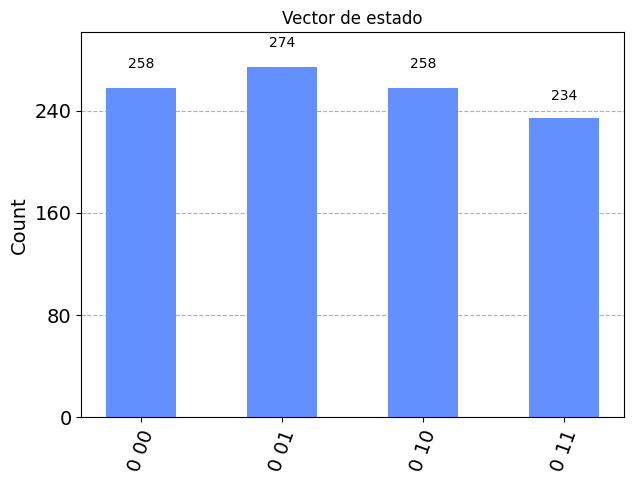

In [20]:
job = execute(circuit, backend_qasm, shots=1024)

plot_histogram(job.result().get_counts(), title="Vector de estado")

Tal y como podemos observar, tras lanzar 1024 disparos a nuestro experimento, serán 4 los posibles estados finales, a pesar de tener 3 $qbits$. Esto se debe a lo visto anteriormente, pues el qbit $q_2$ adoptará siempre el mismo estado final. Y por lo tanto, los estados finales de los qbits restantes oscilarán entre estos cuatro valores con la misma probabilidad, aproximadamente.

Y de esta forma, hemos hecho una muestra práctica de cómo funciona el algoritmo de teleportación.